# Installing MASE (again)

Run the block below to install MASE in the current Colab runtime

In [ ]:
git_token = "YOUR_GIT_TOKEN"
short_code = "YOUR_SHORT_CODE"

# Check the current python version (It should be using Python 3.10) and update pip to the latest version.
!python --version
!python -m pip install --user --upgrade pip

# Clone MASE from your branch (the branch must already exist)
!git clone -b lab1_{short_code} https://{git_token}@github.com/DeepWok/mase.git

# Install requirements
!python -m pip install -r ./mase/machop/requirements.txt

# Change working directory to machop
%cd ./mase/machop/

In [ ]:
!./ch --help

# General introduction

In this lab, you will learn how to use the search functionality in the software stack of MASE.

There are in total 4 tasks you would need to finish.

# Writing a search using MaseGraph Transforms

In this section, our objective is to gain a comprehensive understanding of the construction of the current search function in Mase. To achieve this, we will require these essential components:

- MaseGraph: This component should be already created in the preceding lab.
- Search space: This component encompasses and defines the various available search options.
- Search strategy: An implementation of a search algorithm.
- Runner: This vital component manages and executes training, evaluation, or both procedures while generating a quality metric.

By analyzing these components, we can delve into the workings and effectiveness of the existing search function in Mase.

# Turning your network to a graph

We follow a similar procedure of what you have tried in lab2 to now produce a MaseGraph, this is converted from your pre-trained JSC model:

In [63]:
import sys
import logging
import os
from pathlib import Path
from pprint import pprint as pp

# figure out the correct path
machop_path = Path(".").resolve().parent.parent /"machop"
assert machop_path.exists(), "Failed to find machop at: {}".format(machop_path)
sys.path.append(str(machop_path))

from chop.tools.checkpoint_load import load_model
from chop.dataset import MaseDataModule, get_dataset_info
from chop.tools.logger import set_logging_verbosity

from chop.passes.graph.analysis import (
    report_node_meta_param_analysis_pass,
    profile_statistics_analysis_pass,
)
from chop.passes.graph import (
    add_common_metadata_analysis_pass,
    init_metadata_analysis_pass,
    add_software_metadata_analysis_pass,
)
from chop.tools.get_input import InputGenerator
from chop.ir.graph.mase_graph import MaseGraph

from chop.models import get_model_info, get_model

set_logging_verbosity("info")

batch_size = 8
model_name = "jsc-custom"
dataset_name = "jsc"

data_module = MaseDataModule(
    name=dataset_name,
    batch_size=batch_size,
    model_name=model_name,
    num_workers=0,
    # custom_dataset_cache_path="../../chop/dataset"
)
data_module.prepare_data()
data_module.setup()

model_info = get_model_info(model_name)
model = get_model(
    model_name,
    task="cls",
    dataset_info=data_module.dataset_info,
    pretrained=False,
    checkpoint = None)

LAB1_CUSTOM_PATH = "/home/bkt123/dev/advanced-deep-learning-systems/mase/mase_output/lab-1_jsc-custom/software/training_ckpts/best.ckpt"
model = load_model(load_name=LAB1_CUSTOM_PATH, load_type="pl", model=model)

input_generator = InputGenerator(
    data_module=data_module,
    model_info=model_info,
    task="cls",
    which_dataloader="train",
)

dummy_in = next(iter(input_generator))
_ = model(**dummy_in)

# generate the mase graph and initialize node metadata
mg = MaseGraph(model=model)

INFO     Set logging level to info


INFO     Loaded pytorch lightning checkpoint from /home/bkt123/dev/advanced-deep-learning-systems/mase/mase_output/lab-1_jsc-custom/software/training_ckpts/best.ckpt


# Defining a search space

Based on the previous `pass_args` template, the following code is utilized to generate a search space. The search space is constructed by combining different weight and data configurations in precision setups.

In [64]:
pass_args = {
"by": "type",
"default": {"config": {"name": None}},
"linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
},}

import copy
# build a search space
data_in_frac_widths = [(16, 8), (8, 6), (8, 4), (4, 2)]
w_in_frac_widths = [(16, 8), (8, 6), (8, 4), (4, 2)]
search_spaces = []
for d_config in data_in_frac_widths:
    for w_config in w_in_frac_widths:
        pass_args['linear']['config']['data_in_width'] = d_config[0]
        pass_args['linear']['config']['data_in_frac_width'] = d_config[1]
        pass_args['linear']['config']['weight_width'] = w_config[0]
        pass_args['linear']['config']['weight_frac_width'] = w_config[1]
        # dict.copy() and dict(dict) only perform shallow copies
        # in fact, only primitive data types in python are doing implicit copy when a = b happens
        search_spaces.append(copy.deepcopy(pass_args))

## Defining a search strategy and a runner

The code provided below consists of two main `for` loops. The first `for` loop executes a straightforward brute-force search, enabling the iteration through the previously defined search space.

In contrast, the second `for` loop retrieves training samples from the train data loader. These samples are then utilized to generate accuracy and loss values, which serve as potential quality metrics for evaluating the system's performance.


In [60]:
# grid search
import torch
import time
from torchmetrics.classification import MulticlassAccuracy

from chop.passes.graph.transforms import (
    quantize_transform_pass,
    summarize_quantization_analysis_pass,
)
from chop.passes.graph.analysis.flops.flops_pass import analyse_flops_pass

mg, _ = init_metadata_analysis_pass(mg, None)
mg, _ = add_common_metadata_analysis_pass(mg, {"dummy_in": dummy_in})
mg, _ = add_software_metadata_analysis_pass(mg, None)

metric = MulticlassAccuracy(num_classes=5)
num_batchs = 250
# This first loop is basically our search strategy,
# in this case, it is a simple brute force search

recorded_accs = []
latencies = []
total_flops = []
total_bitops = []
for i, config in enumerate(search_spaces):
    mg, _ = quantize_transform_pass(mg, config)

    mg = analyse_flops_pass(mg, silent=True)
    j = 0

    # this is the inner loop, where we also call it as a runner.
    acc_avg, loss_avg = 0, 0
    accs, losses = [], []
    lats = []
    for inputs in data_module.train_dataloader():
        xs, ys = inputs
        start = time.time()
        preds = mg.model(xs)
        lats.append(time.time() - start)
        loss = torch.nn.functional.cross_entropy(preds, ys)
        acc = metric(preds, ys)
        accs.append(acc)
        losses.append(loss)
        if j > num_batchs:
            break
        j += 1

    flops = 0
    for node in mg.nodes:
        flops_data = node.meta['mase'].parameters['software']['computations']
        if flops_data:
            flops += flops_data['computations']
            flops += flops_data['backward_computations']

    bitops = 0
    for node in mg.nodes:
        bitops_data = node.meta['mase'].parameters['software']['computations']
        if bitops_data:
            bitops += bitops_data['forward_bitops']
            bitops += bitops_data['backward_bitops']

    acc_avg = sum(accs) / len(accs)
    loss_avg = sum(losses) / len(losses)
    recorded_accs.append(acc_avg)
    latency_avg = sum(lats) / len(lats)
    latencies.append(latency_avg)
    total_flops.append(flops)
    total_bitops.append(bitops)

In [8]:
search_spaces

[{'default': {'config': {'name': None}},
  'linear': {'config': {'name': 'integer',
    'data_in_width': 16,
    'data_in_frac_width': 8,
    'weight_width': 16,
    'weight_frac_width': 8,
    'bias_width': 8,
    'bias_frac_width': 4}}},
 {'default': {'config': {'name': None}},
  'linear': {'config': {'name': 'integer',
    'data_in_width': 16,
    'data_in_frac_width': 8,
    'weight_width': 8,
    'weight_frac_width': 6,
    'bias_width': 8,
    'bias_frac_width': 4}}},
 {'default': {'config': {'name': None}},
  'linear': {'config': {'name': 'integer',
    'data_in_width': 16,
    'data_in_frac_width': 8,
    'weight_width': 8,
    'weight_frac_width': 4,
    'bias_width': 8,
    'bias_frac_width': 4}}},
 {'default': {'config': {'name': None}},
  'linear': {'config': {'name': 'integer',
    'data_in_width': 16,
    'data_in_frac_width': 8,
    'weight_width': 4,
    'weight_frac_width': 2,
    'bias_width': 8,
    'bias_frac_width': 4}}},
 {'default': {'config': {'name': None}},
  

In [10]:

print("| Trial | Data In | Weight | Bias |")
print("| --- | --- | --- | --- |")
for i, space in enumerate(search_spaces):
    cfg = space['linear']['config']
    # Print a table
    print(f"| {i} | ({cfg['data_in_width']}, {cfg['data_in_frac_width']}) | ({cfg['weight_width']}, {cfg['weight_frac_width']}) | ({cfg['bias_width']}, {cfg['bias_frac_width']}) |")

| Trial | Data In | Weight | Bias |
| --- | --- | --- | --- |
| 0 | (16, 8) | (16, 8) | (8, 4) |
| 1 | (16, 8) | (8, 6) | (8, 4) |
| 2 | (16, 8) | (8, 4) | (8, 4) |
| 3 | (16, 8) | (4, 2) | (8, 4) |
| 4 | (8, 6) | (16, 8) | (8, 4) |
| 5 | (8, 6) | (8, 6) | (8, 4) |
| 6 | (8, 6) | (8, 4) | (8, 4) |
| 7 | (8, 6) | (4, 2) | (8, 4) |
| 8 | (8, 4) | (16, 8) | (8, 4) |
| 9 | (8, 4) | (8, 6) | (8, 4) |
| 10 | (8, 4) | (8, 4) | (8, 4) |
| 11 | (8, 4) | (4, 2) | (8, 4) |
| 12 | (4, 2) | (16, 8) | (8, 4) |
| 13 | (4, 2) | (8, 6) | (8, 4) |
| 14 | (4, 2) | (8, 4) | (8, 4) |
| 15 | (4, 2) | (4, 2) | (8, 4) |


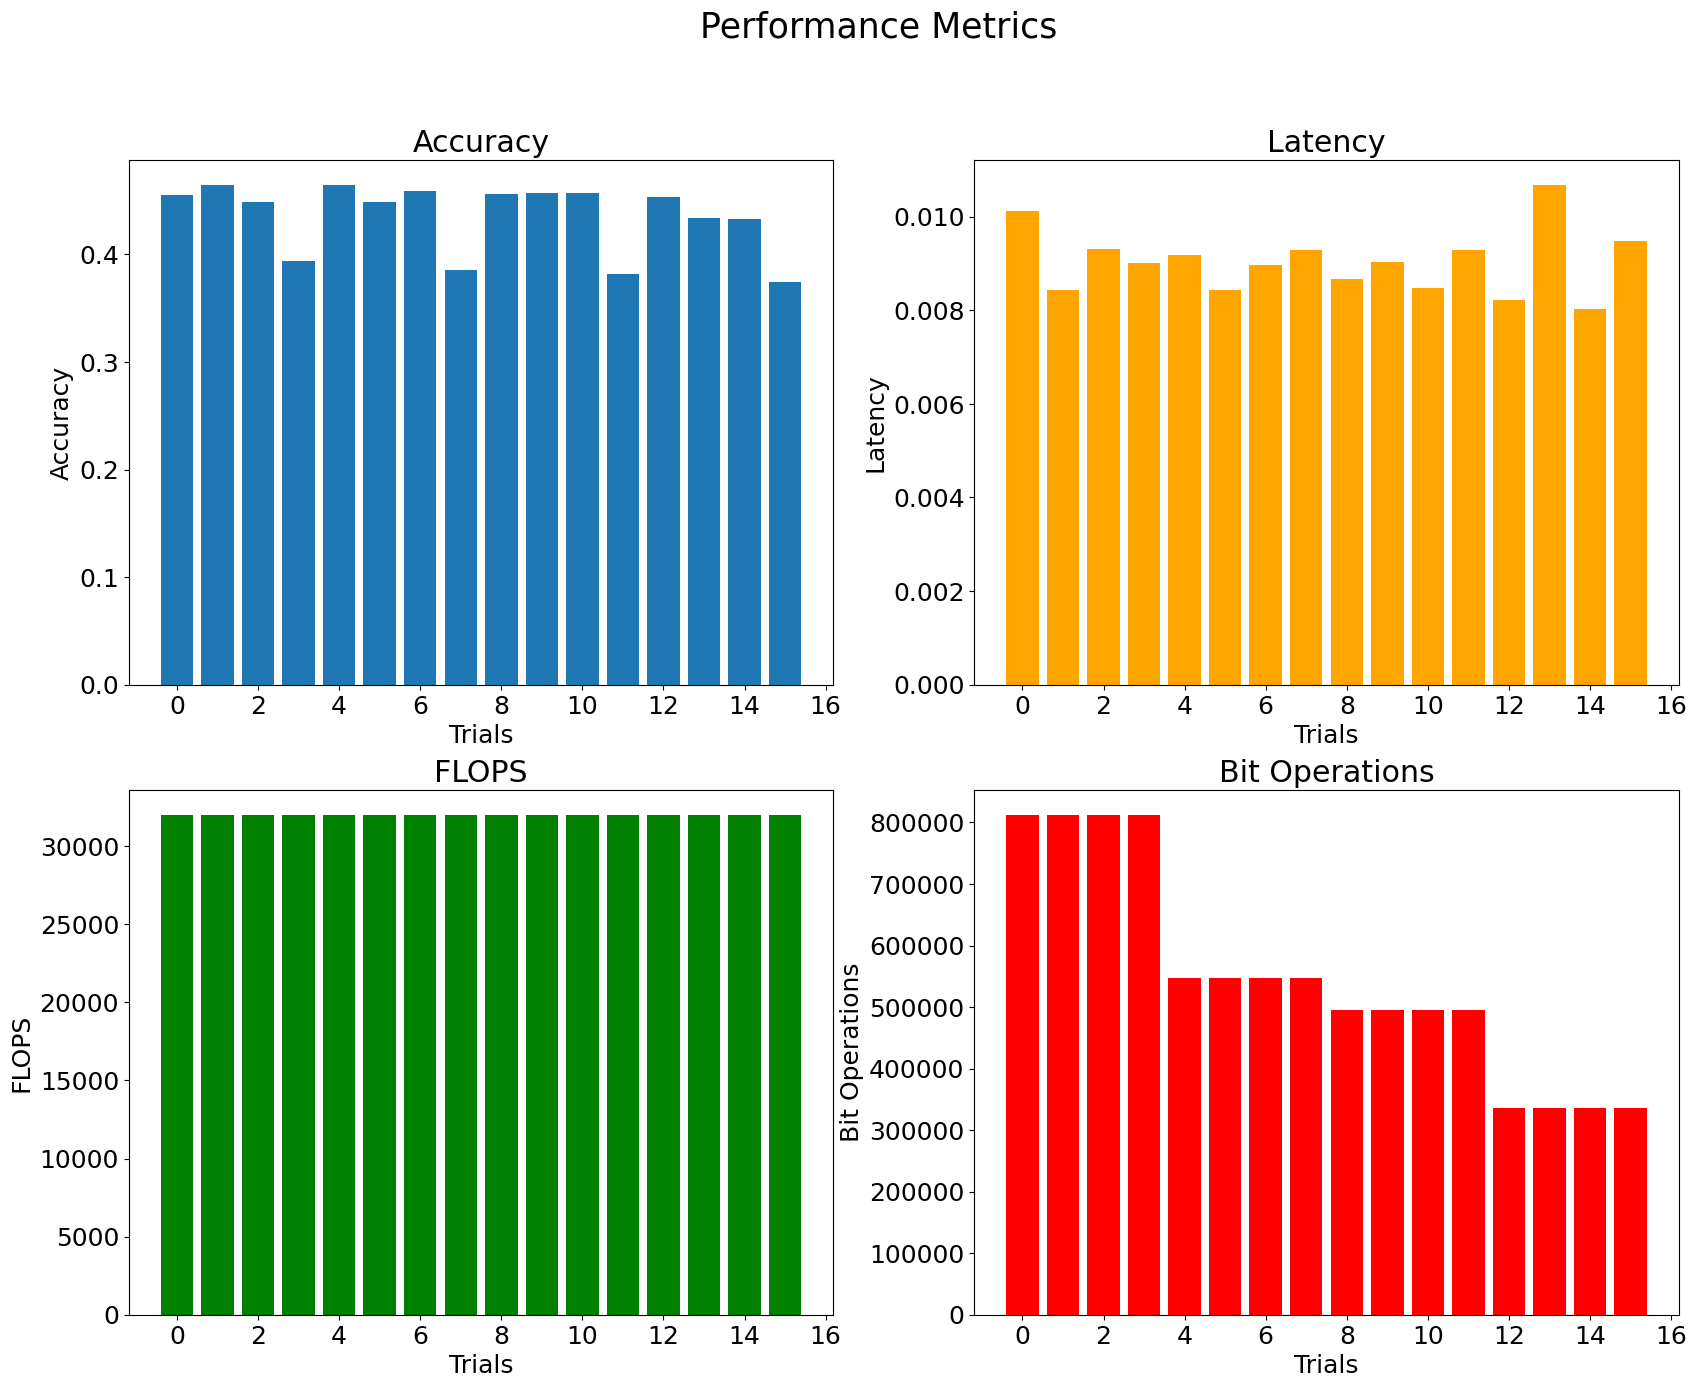

In [61]:
# Give me good plots of the accuracy, latency, flops and bitops. Bar graphs

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Performance Metrics', fontsize=25)

plt.rcParams.update({'font.size': 18})

ax[0, 0].bar(np.arange(len(recorded_accs)), recorded_accs)
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_xlabel('Trials')
ax[0, 0].set_ylabel('Accuracy')

ax[0, 1].bar(np.arange(len(latencies)), latencies, color='orange')
ax[0, 1].set_title('Latency')
ax[0, 1].set_xlabel('Trials')
ax[0, 1].set_ylabel('Latency')

ax[1, 0].bar(np.arange(len(total_flops)), total_flops, color='green')
ax[1, 0].set_title('FLOPS')
ax[1, 0].set_xlabel('Trials')
ax[1, 0].set_ylabel('FLOPS')

ax[1, 1].bar(np.arange(len(total_bitops)), total_bitops, color='red')
ax[1, 1].set_title('Bit Operations')
ax[1, 1].set_xlabel('Trials')
ax[1, 1].set_ylabel('Bit Operations')

plt.show()

In [4]:
print([a.item() for a in recorded_accs])
print(latencies)
print(total_flops)
print(total_bitops)

[0.5523809790611267, 0.5166667103767395, 0.4595238268375397, 0.23523809015750885, 0.31904762983322144, 0.47857144474983215, 0.285714328289032, 0.28333333134651184, 0.2909524142742157, 0.45714282989501953, 0.4035714566707611, 0.42023810744285583, 0.41428571939468384, 0.5285714268684387, 0.32476189732551575, 0.3023809790611267]
[0.0030844552176339285, 0.0022642271859305246, 0.00225482668195452, 0.0022152832576206754, 0.0028856141226632254, 0.002224615642002651, 0.002100024904523577, 0.0018821103232247488, 0.0018491744995117188, 0.0018437249319893973, 0.0018757411411830357, 0.0018695081983293807, 0.001842226300920759, 0.0018641948699951172, 0.0018393312181745256, 0.0018300328935895646]
[32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0, 32016.0]
[812544.0, 812544.0, 812544.0, 812544.0, 547584.0, 547584.0, 547584.0, 547584.0, 494592.0, 494592.0, 494592.0, 494592.0, 335616.0, 335616.0, 335616.0, 335616.0]


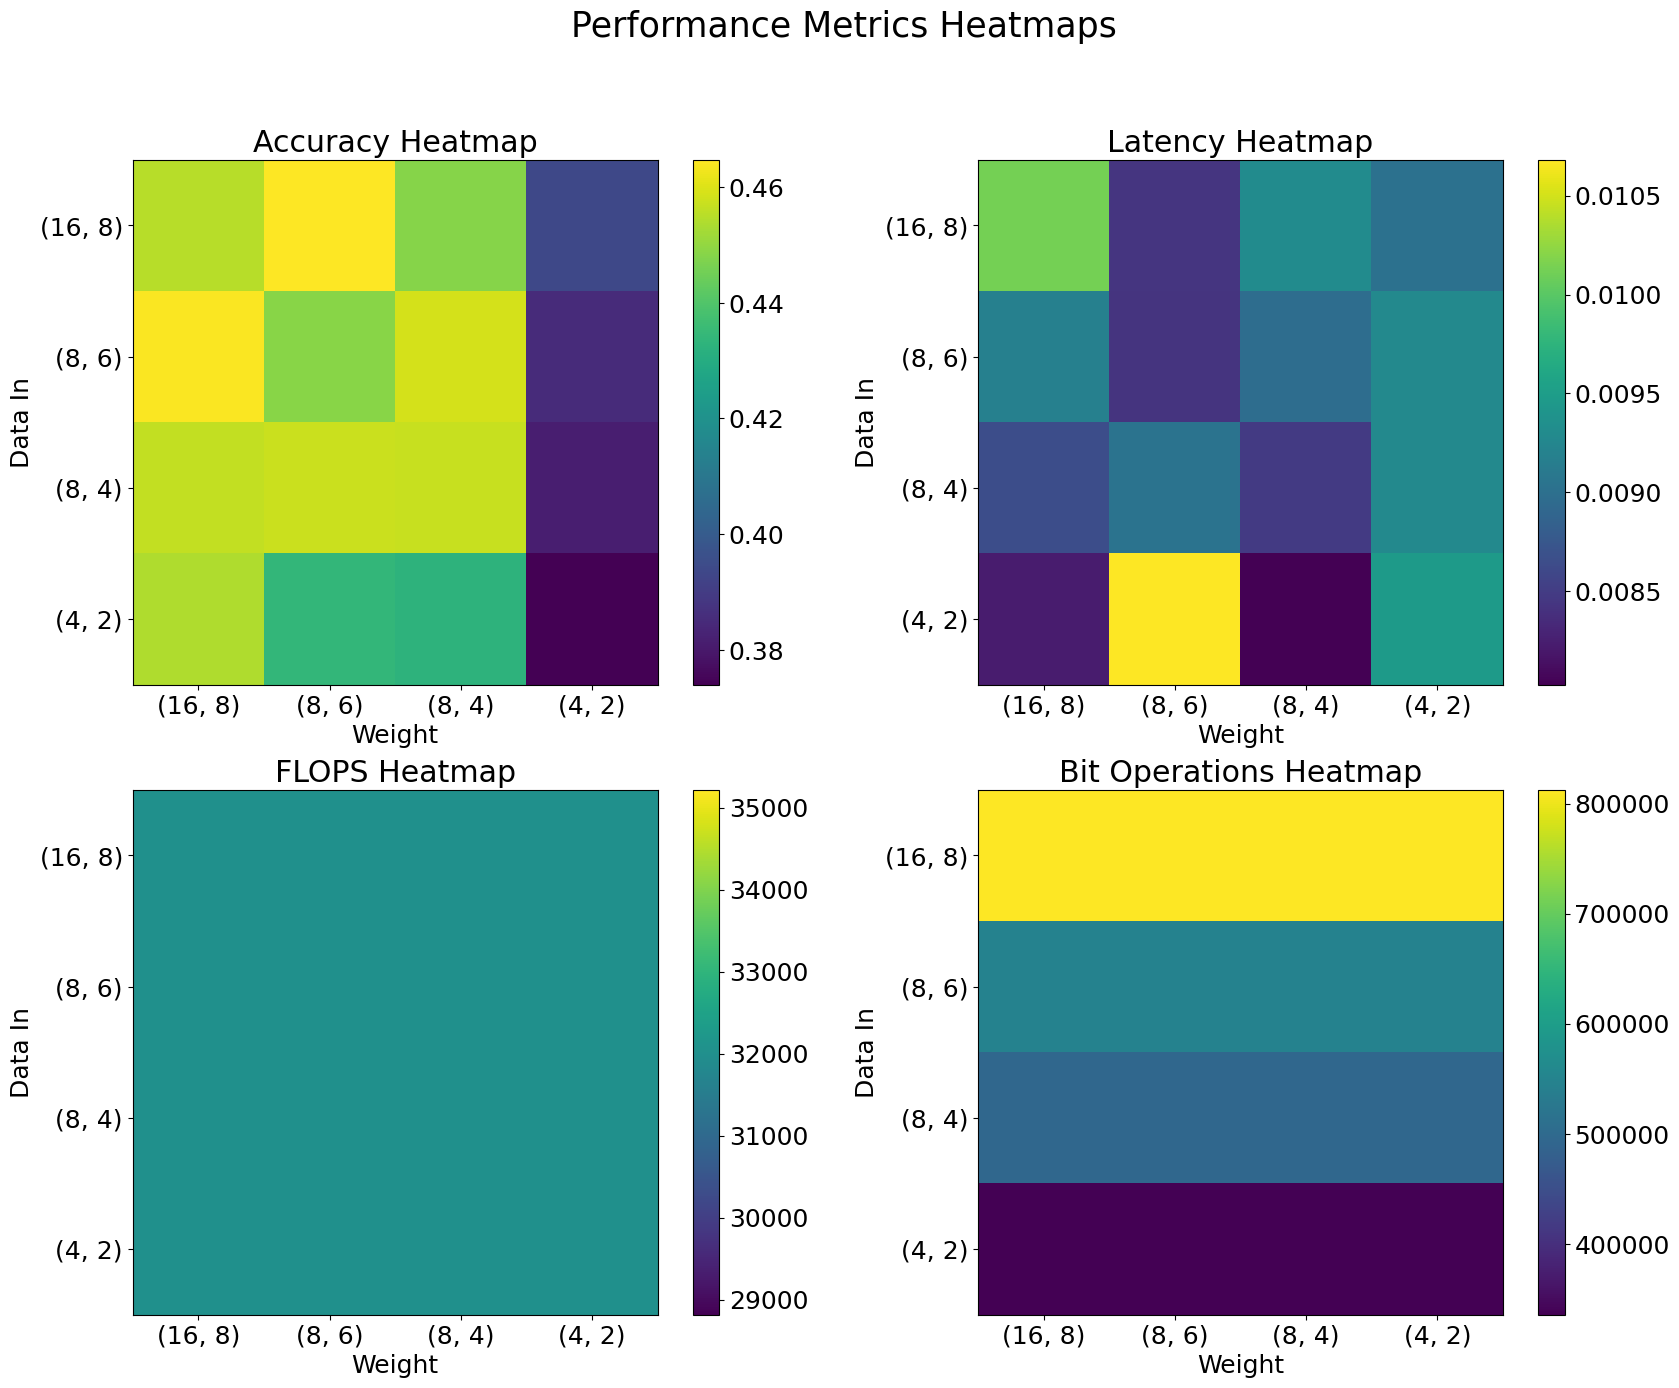

In [62]:
import numpy as np
import matplotlib.pyplot as plt

accuracies = [a.item() for a in recorded_accs]

data_in_pairs = [(16, 8), (8, 6), (8, 4), (4, 2)]
weight_pairs = [(16, 8), (8, 6), (8, 4), (4, 2)]

# Sorting "Data In" and "Weight" pairs by their first element
sorted_data_in = data_in_pairs # sorted(data_in_pairs, key=lambda x: x[0])
sorted_weight = weight_pairs # sorted(weight_pairs, key=lambda x: x[0])

# Mapping sorted "Data In" and "Weight" to their corresponding indices
data_in_indices = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
weight_indices = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]

# Create a 4x4 matrix to store the results
heatmap_accuracies = np.zeros((4, 4))
heatmap_latencies = np.zeros((4, 4))
heatmap_flops = np.zeros((4, 4))
heatmap_bitops = np.zeros((4, 4))

# Fill the matrix with the results
for data_in, weight, idx in zip(data_in_indices, weight_indices, list(range(16))):
    heatmap_accuracies[data_in, weight] = accuracies[idx]
    heatmap_latencies[data_in, weight] = latencies[idx]
    heatmap_flops[data_in, weight] = total_flops[idx]
    heatmap_bitops[data_in, weight] = total_bitops[idx]
    
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Performance Metrics Heatmaps', fontsize=25)

plt.rcParams.update({'font.size': 18})

data_in_labels = [str(pair) for pair in sorted_data_in]
weight_labels = [str(pair) for pair in sorted_weight]

# Plotting the heatmap for accuracies
im = ax[0, 0].imshow(heatmap_accuracies, cmap='viridis', interpolation='nearest')
plt.sca(ax[0, 0])
plt.colorbar(im)
plt.xticks(ticks=np.arange(4), labels=weight_labels)
plt.yticks(ticks=np.arange(4), labels=data_in_labels)
plt.xlabel('Weight')
plt.ylabel('Data In')
plt.title('Accuracy Heatmap')

# Plotting the heatmap for latencies
im = ax[0, 1].imshow(heatmap_latencies, cmap='viridis', interpolation='nearest')
plt.sca(ax[0, 1])
plt.xticks(ticks=np.arange(4), labels=weight_labels)
plt.yticks(ticks=np.arange(4), labels=data_in_labels)
plt.xlabel('Weight')
plt.ylabel('Data In')
plt.title('Latency Heatmap')
plt.colorbar(im)
# Plotting the heatmap for flops
im = ax[1, 0].imshow(heatmap_flops, cmap='viridis', interpolation='nearest')
plt.sca(ax[1, 0])
plt.xticks(ticks=np.arange(4), labels=weight_labels)
plt.yticks(ticks=np.arange(4), labels=data_in_labels)
plt.xlabel('Weight')
plt.ylabel('Data In')
plt.title('FLOPS Heatmap')
plt.colorbar(im)

# Plotting the heatmap for bitops
im = ax[1, 1].imshow(heatmap_bitops, cmap='viridis', interpolation='nearest')
plt.sca(ax[1, 1])
plt.xticks(ticks=np.arange(4), labels=weight_labels)
plt.yticks(ticks=np.arange(4), labels=data_in_labels)
plt.xlabel('Weight', position=(0.5, 0))
plt.ylabel('Data In')
plt.title('Bit Operations Heatmap')
plt.colorbar(im)

plt.show()



We now have the following task for you:

1. Explore additional metrics that can serve as quality metrics for the search process. For example, you can consider metrics such as latency, model size, or the number of FLOPs (floating-point operations) involved in the model.

2. Implement some of these additional metrics and attempt to combine them with the accuracy or loss quality metric. It's important to note that in this particular case, accuracy and loss actually serve as the same quality metric (do you know why?).



# The search command in the MASE flow

The search flow implemented in MASE is very similar to the one that you have constructed manually, the overall flow is implemented in [search.py](../../machop/chop/actions/search/search.py), the following bullet points provide you pointers to the code base.

- MaseGraph: this is the [MaseGraph](../../machop/chop/passes/graph/mase_graph.py) that you have used in lab2.
- Search space: The base class is implemented in [base.py](../../machop/chop/actions/search/search_space/base.py) , where in the same folder you can see a range of different supported search spaces.
- Search strategy: Similar to the search space, you can find a a base class [definition](../../machop/chop/actions/search/strategies/base.py), where different strategies are also defined in the same folder.
- Runner: Different [runners](../../machop/chop/actions/search/strategies/runners) can produce different metrics, they may also use `transforms` to help compute certain search metrics.

This enables one to execute the search through the MASE command line interface, remember to change the name after the `--load` option.


In [ ]:
! ./ch search --config configs/examples/jsc_toy_by_type.toml --load your_pre_trained_ckpt

In this scenario, the search functionality is specified in the `toml` configuration file rather than via command-line inputs. This approach is adopted due to the multitude of configuration parameters that need to be set; encapsulating them within a single, elegant configuration file enhances reproducibility.

In `jsc_toy_by_type.toml`, the `search_space` configuration is set in `search.search_space`, the search strategy is configured via `search.strategy`. If you are not familiar with the `toml` syntax, you can read [here](https://toml.io/en/v1.0.0).

> In order to accomplish the following task, it is necessary to make direct modifications to the code base. This can be challenging within the Colab environment. **It is recommended to implement the task on a local setup and utilize Colab strictly as a server to execute the search command above.** Consider Colab as a dedicated server for this purpose.

With now an understanding of how the MASE flow work, consider the following tasks

3. Implement the brute-force search as an additional search method within the system, this would be a new search strategy in MASE.
4. Compare the brute-force search with the TPE based search, in terms of sample efficiency. Comment on the performance difference between the two search methods.

In [51]:
import os
print(os.getcwd())

/home/bkt123/dev/advanced-deep-learning-systems/mase/docs/labs


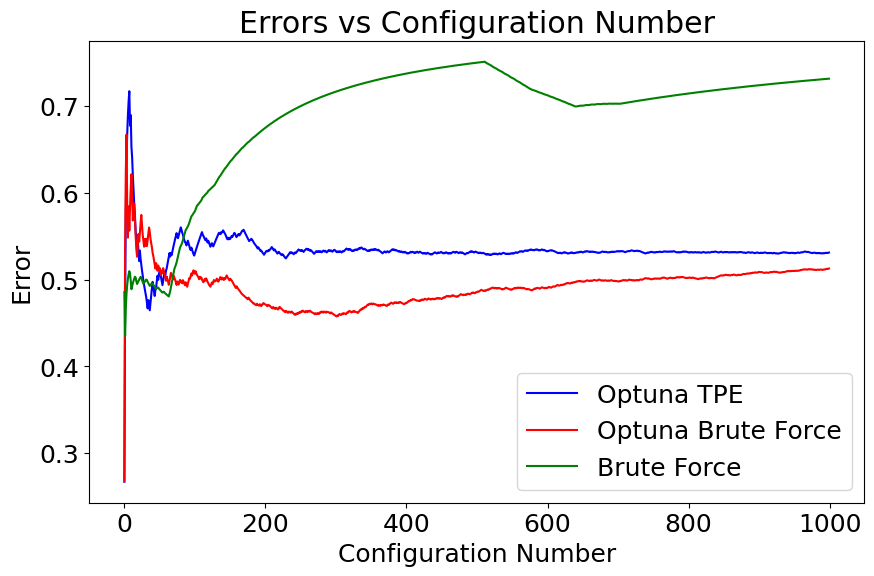

In [57]:
# Plot the results of models trained on the command line

import json
import matplotlib.pyplot as plt

# Specify the path to your JSON file
file_path1  = '../../mase_output/lab-3_search-tpe/software/search_ckpts/log.json'
file_path2  = '../../mase_output/lab-3_search-bf/software/search_ckpts/log.json'
file_path3  = '../../mase_output/lab-3_search-bf-manual/software/search_ckpts/results.json'


def load_optuna_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    config_numbers = []
    accuracies = []
    for key, value in data.items():
        config_number = int(key)
        accuracy = value.get("user_attrs_software_metrics", {}).get("accuracy")
        config_numbers.append(config_number)
        accuracies.append(accuracy)
    return config_numbers, accuracies

def load_custom_data(file_path):
    with open(file_path, 'r') as file:
            data = json.load(file)
    config_numbers = []
    accuracies = []
    for key, value in data.items():
        config_number = int(key)
        accuracy = value.get("metrics").get("accuracy")
        config_numbers.append(config_number)
        accuracies.append(accuracy)
    return config_numbers, accuracies
    

# Load and extract data from both files
config_numbers1, accuracies1 = load_optuna_data(file_path1)
config_numbers2, accuracies2 = load_optuna_data(file_path2)
config_numbers3, accuracies3 = load_custom_data(file_path3)

errors1 = [1 - accuracy for accuracy in accuracies1]
errors2 = [1 - accuracy for accuracy in accuracies2]
errors3 = [1 - accuracy for accuracy in accuracies3]


# Plotting
plt.figure(figsize=(10, 6))

# Plot data from the first file
plt.plot(config_numbers1[0:1000], errors1[0:1000], color='blue', label='Optuna TPE')

# Plot data from the second file
plt.plot(config_numbers2[0:1000], errors2[0:1000], color='red', label='Optuna Brute Force')

# Plot data from the third file
plt.plot(config_numbers3[0:1000], errors3[0:1000], color='green', label='Brute Force')

plt.title('Errors vs Configuration Number')
plt.xlabel('Configuration Number')
plt.ylabel('Error')
plt.legend()
plt.grid(False)
plt.show()